In [1]:
from typing import Any
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
torch.backends.mps.is_available(), torch.cuda.is_available()

(True, False)

In [3]:
DATA_DIR = 'data/'

# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)

magic_number_1 = 0.1307
magic_number_2 = 0.3081

transform_for_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (magic_number_1,),
            (magic_number_2,)
        )
    ]
)

train_dataset = torchvision.datasets.FashionMNIST(
    DATA_DIR,
    train=True,
    download=True,
    transform=transform_for_data,
)

test_dataset = torchvision.datasets.FashionMNIST(
    DATA_DIR,
    train=False,
    download=True,
    transform=transform_for_data,
)

In [4]:
# Use the following code to create a validation set of 10%
split_size = 0.1

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=split_size,
)

In [5]:
# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)

# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)

print(num_train_batches)
print(num_val_batches)
print(num_test_batches)

106
12
40


In [6]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim: int, output_dim: int, hidden_layer_dims: list[int], activation_function: callable = F.relu): 
        super(ACAIGFCN, self).__init__()

        #Define the network layer(s) and activation function(s)
        if not hidden_layer_dims:
            raise ValueError(f"No middle layers provided, expected at least one.")
        
        layers = []
        prev_dim = input_dim
        for dim in hidden_layer_dims:
            layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, output_dim))

        self.layers = nn.ModuleList(layers)
        self.activation_function = activation_function
 
    def forward(self, x):
        #Define how your model propagates the input through the network
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
        
        final_layer = self.layers[-1]
        return final_layer(x)
    
# model = ACAIGFCN(784, 10, [1024, 512, 128, 32])

In [14]:
def custom_accuracy_metric(y_hat, y_truth):
    return (torch.argmax(y_hat, dim=1) == y_truth).type(torch.FloatTensor).mean()

In [ ]:
FASHION_MNIST_INPUT_DIM = 784
FASHION_MNIST_OUTPUT_DIM = 10


class ModelTrainingArtifact():
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        objective: nn.Module,
        num_epochs: int,
        hidden_layer_dims: list[int],
        activation_function: callable,
        optimizer_hyperparams: dict[str, Any],
        accuracy_metric: callable = custom_accuracy_metric,
        train_batches: DataLoader = train_batches,
        val_batches: DataLoader = val_batches,
        test_batches: DataLoader = test_batches,
    ):
        """"""
        self.model = ACAIGFCN(
            input_dim=FASHION_MNIST_INPUT_DIM,
            output_dim=FASHION_MNIST_OUTPUT_DIM,
            hidden_layer_dims=hidden_layer_dims,
            activation_function=activation_function,
        )
        self.optimizer = optimizer(self.model.parameters(), **optimizer_hyperparams)
        self.objective = objective
        self.train_batches = train_batches
        self.val_batches = val_batches
        self.test_batches = test_batches
        self.num_epochs = num_epochs
        self.accuracy_metric: callable = accuracy_metric

    def train(self):
        """"""
        self.train_loss = []
        self.validation_loss = []
        self.train_accuracy = []
        self.validation_accuracy = []

        loop = tqdm(total=len(train_batches) * self.num_epochs, position=0)

        # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
        # Track the loss and validation accuracy
        for epoch in range(self.num_epochs):

            # ACAIGFCN Training 
            for train_features, train_labels in self.train_batches:
                # Set model into training mode
                self.model.train()
                
                # Reshape images into a vector
                train_features = train_features.reshape(-1, 28*28)

                self.optimizer.zero_grad()

                y_hat = self.model(train_features)
                loss = self.objective(y_hat, train_labels)

                loss.backward()
                self.optimizer.step()
                
                # loop.set_description(f"Epoch {epoch+1}/{epochs}")
                # loop.update(1)

                # Reset gradients, Calculate training loss on model 
                # Perfrom optimization, back propagation
                train_accuracy = self.accuracy_metric(y_hat, train_labels)
                self.train_accuracy.append(train_accuracy)
        
                # Record loss for the epoch
                self.train_loss.append(loss.item())

                loop.set_description('epoch:{} train loss:{:.4f} train accuracy:{:.4f}'.format(epoch, self.train_loss[-1], train_accuracy))
                loop.update(1)

            current_val_acc = []
            current_val_loss = []
            
            # ACAIGFCN Validation
            for val_features, val_labels in self.val_batches:
                
                # Telling PyTorch we aren't passing inputs to network for training purpose
                with torch.no_grad(): 
                    self.model.eval()
                    
                    # Reshape validation images into a vector
                    val_features = val_features.reshape(-1, 28*28)

                    y_hat = self.model(val_features)
                    val_loss = self.objective(y_hat, val_labels)
                
                    # Compute validation outputs (targets) 
                    # and compute accuracy
                    val_accuracy = self.accuracy_metric(y_hat, val_labels)
                    current_val_acc.append(val_accuracy)
                    current_val_loss.append(val_loss.item())

            self.validation_accuracy.append((len(self.train_accuracy), np.mean(current_val_acc)))
            self.validation_loss.append((len(self.train_loss), np.mean(current_val_loss)))

        loop.close()

    def test(self):
        """"""
        test_acc = []
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad():
            
            for test_features, test_labels in self.test_batches:

                self.model.eval()
                # Reshape test images into a vector
                test_features = test_features.reshape(-1, 28*28)

                # Compute validation outputs (targets) 
                y_hat = self.model(test_features)
                test_acc.append(self.accuracy_metric(y_hat, test_labels))
                # and compute accuracy 
            
            # Compute total (mean) accuracy
            # Report total (mean) accuracy, can also compute std based on batches

        self.mean_test_accuracy = np.mean(test_acc)
        self.std_test_accuracy = np.std(test_acc)

        print(f"Mean Accuracy Across Each Batch of the test set: {self.mean_test_accuracy:.4f} ± {self.std_test_accuracy:.5f}")

In [19]:
model_with_sgd = ModelTrainingArtifact(
    optimizer=torch.optim.SGD,
    objective=nn.CrossEntropyLoss(),
    num_epochs=50,
    hidden_layer_dims=[1024, 256, 16],
    activation_function=F.relu,
    optimizer_hyperparams={'lr': 0.001, 'momentum': 0.9},
)
model_with_sgd.train()
model_with_sgd.test()

epoch:49 train loss:0.2503 train accuracy:0.9250: 100%|██████████| 5300/5300 [02:52<00:00, 30.72it/s]


Mean Accuracy Across Each Batch of the test set: 0.8614 ± 0.02093


In [20]:
model_with_sgd2 = ModelTrainingArtifact(
    optimizer=torch.optim.SGD,
    objective=nn.CrossEntropyLoss(),
    num_epochs=30,
    hidden_layer_dims=[1024, 512, 256, 128, 64, 32, 16],
    activation_function=F.relu,
    optimizer_hyperparams={'lr': 0.01, 'momentum': 0.25},
)
model_with_sgd2.train()
model_with_sgd2.test()

epoch:29 train loss:0.8018 train accuracy:0.7083: 100%|██████████| 3180/3180 [01:52<00:00, 28.23it/s]


Mean Accuracy Across Each Batch of the test set: 0.6885 ± 0.04072


In [21]:
model_with_sgd3 = ModelTrainingArtifact(
    optimizer=torch.optim.SGD,
    objective=nn.CrossEntropyLoss(),
    num_epochs=50,
    hidden_layer_dims=[1024, 512, 256, 128, 64, 32, 16],
    activation_function=F.relu,
    optimizer_hyperparams={'lr': 0.003, 'momentum': 0.1},
)
model_with_sgd3.train()
model_with_sgd3.test()

epoch:49 train loss:2.2948 train accuracy:0.2250: 100%|██████████| 5300/5300 [03:14<00:00, 27.28it/s]


Mean Accuracy Across Each Batch of the test set: 0.1786 ± 0.02052


In [22]:
model_with_sgd3 = ModelTrainingArtifact(
    optimizer=torch.optim.Adam,
    objective=nn.CrossEntropyLoss(),
    num_epochs=50,
    hidden_layer_dims=[1024, 512, 128, 32],
    activation_function=F.relu,
    optimizer_hyperparams={'lr': 0.003, 'betas': (0.85, 0.9)},
)
model_with_sgd3.train()
model_with_sgd3.test()

epoch:49 train loss:0.0550 train accuracy:0.9750: 100%|██████████| 5300/5300 [03:26<00:00, 25.65it/s]


Mean Accuracy Across Each Batch of the test set: 0.8954 ± 0.02284


In [ ]:
# # Initialize neural network model with input, output and hidden layer dimensions
# model = ACAIGFCN(784, 10, [1024, 512, 256, 128, 64, 32, 16]) #... add more parameters
                
# # Define the learning rate and epochs number
# learning_rate = 0.003
# epochs = 25


# train_loss_list = np.zeros((epochs,))
# validation_accuracy_list = np.zeros((epochs,))

# # Define loss function  and optimizer
# loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Use optimizers from torch.optim

In [ ]:
# # Run your training and validation loop and collect stats
# train_loss = []
# val_loss = []
# train_acc = []
# val_acc = []

# # TODO: Is this a good way to calculate accuracy?
# def acc(y_h, y_t):
#     return (torch.softmax(y_h, 1).argmax(1) == y_t).float().mean()


# loop = tqdm(total=len(train_batches) * epochs, position=0)

# # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
# # Track the loss and validation accuracy
# for epoch in range(epochs):

#     # ACAIGFCN Training 
#     for train_features, train_labels in train_batches:
#         # Set model into training mode
#         model.train()
        
#         # Reshape images into a vector
#         train_features = train_features.reshape(-1, 28*28)

#         optimizer.zero_grad()

#         y_hat = model(train_features)
#         loss = loss_func(y_hat, train_labels)

#         loss.backward()
#         optimizer.step()
        
#         # loop.set_description(f"Epoch {epoch+1}/{epochs}")
#         # loop.update(1)

#         # Reset gradients, Calculate training loss on model 
#         # Perfrom optimization, back propagation
#         train_accuracy = acc(y_hat, train_labels)
#         train_acc.append(train_accuracy)
 
#         # Record loss for the epoch
#         train_loss.append(loss.item())

#         loop.set_description('epoch:{} train loss:{:.4f} train accuracy:{:.4f}'.format(epoch, train_loss[-1], train_accuracy))
#         loop.update(1)

#     current_val_acc = []
#     current_val_loss = []
    
#     # ACAIGFCN Validation
#     for val_features, val_labels in val_batches:
        
#         # Telling PyTorch we aren't passing inputs to network for training purpose
#         with torch.no_grad(): 
#             model.eval()
            
#              # Reshape validation images into a vector
#             val_features = val_features.reshape(-1, 28*28)

#             y_hat = model(val_features)
#             loss = loss_func(y_hat, val_labels)
          
#             # Compute validation outputs (targets) 
#             # and compute accuracy
#             val_accuracy = acc(y_hat, val_labels)
#             current_val_acc.append(val_accuracy)
#             current_val_loss.append(loss.item())

#     val_acc.append((len(train_acc), np.mean(current_val_acc)))
#     val_loss.append((len(train_loss), np.mean(current_val_loss)))

#     # loop.set_description(
#     #     f"epoch:{epoch} train loss:{train_loss[-1]:.4f} train accuracy:{train_accuracy:.4f} val loss:{val_loss[-1][-1]:.4f} val accuracy:{val_acc[-1][-1]:.4f}"
#     # )
#     # loop.update(1)
            
#     # Record accuracy for the epoch; print training loss, validation accuracy
#     # print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(val_acc/num_val_batches*100) + '%')

# loop.close()

  0%|          | 0/2650 [00:00<?, ?it/s]

epoch:24 train loss:0.3355 train accuracy:0.8792: 100%|██████████| 2650/2650 [01:34<00:00, 27.91it/s]


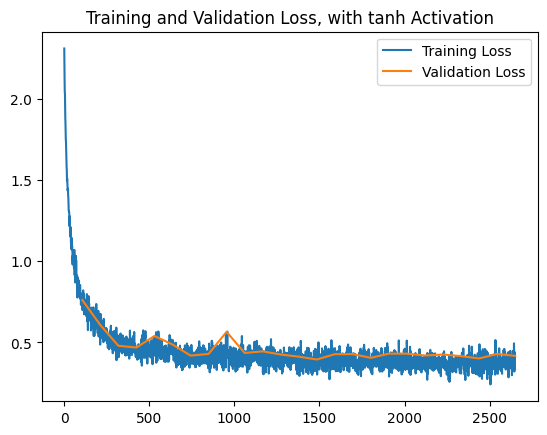

In [14]:
# Plot training loss and validation accuracy throughout the training epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(np.array(val_loss)[:,0], np.array(val_loss)[:,1], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss, with tanh Activation')
plt.show()

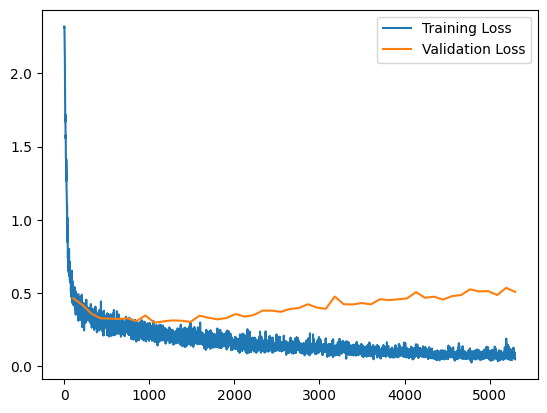

In [21]:
# Plot training loss and validation accuracy throughout the training epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(np.array(val_loss)[:,0], np.array(val_loss)[:,1], label='Validation Loss')
plt.legend()
plt.show()

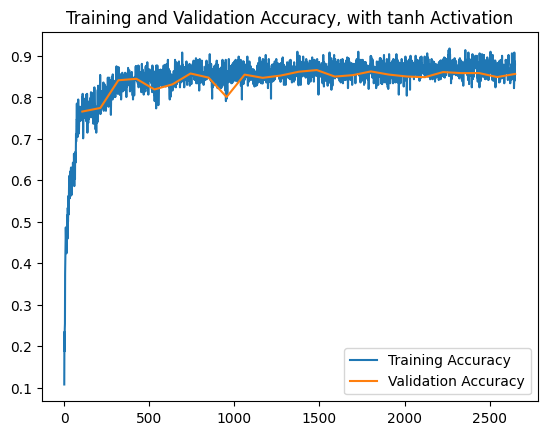

In [15]:
# Plot training loss and validation accuracy throughout the training epochs
plt.plot(train_acc, label='Training Accuracy')
plt.plot(np.array(val_acc)[:,0], np.array(val_acc)[:,1], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy, with tanh Activation')
plt.show()

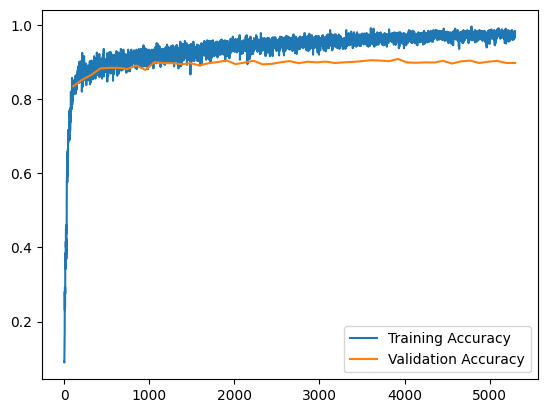

In [22]:
# Plot training loss and validation accuracy throughout the training epochs
plt.plot(train_acc, label='Training Accuracy')
plt.plot(np.array(val_acc)[:,0], np.array(val_acc)[:,1], label='Validation Accuracy')
plt.legend()
plt.show()

In [26]:
#Calculate accuracy on test set

test_acc = []

# Telling PyTorch we aren't passing inputs to network for training purpose
with torch.no_grad():
    
    for test_features, test_labels in test_batches:

        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

        # Compute validation outputs (targets) 
        y_hat = model(test_features)
        test_acc.append(acc(y_hat, test_labels))
        # and compute accuracy 
    
    # Compute total (mean) accuracy
    # Report total (mean) accuracy, can also compute std based on batches

print(f"Mean Accuracy Across Each Batch of the test set: {np.mean(test_acc):.4f} ± {np.std(test_acc):.5f}")

Mean Accuracy Across Each Batch of the test set: 0.8905 ± 0.02280


In [16]:
#Calculate accuracy on test set

test_acc = []

# Telling PyTorch we aren't passing inputs to network for training purpose
with torch.no_grad():
    
    for test_features, test_labels in test_batches:

        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

        # Compute validation outputs (targets) 
        y_hat = model(test_features)
        test_acc.append(acc(y_hat, test_labels))
        # and compute accuracy 
    
    # Compute total (mean) accuracy
    # Report total (mean) accuracy, can also compute std based on batches

print(f"Mean Accuracy Across Each Batch of the test set: {np.mean(test_acc):.4f} ± {np.std(test_acc):.5f}")

Mean Accuracy Across Each Batch of the test set: 0.8416 ± 0.02486


In [19]:
#Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")

# # Sample code to plot N^2 images from the dataset
# def plot_images(XX, N, title):
#     fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
#     for i in range(N):
#       for j in range(N):
#         ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
#         ax[i,j].axis("off")
#     fig.suptitle(title, fontsize=24)

# plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )    